# Spaceship Titanic 
## Libraries
Import the neccesary libraries needed for the data analysis.

In [114]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Inspecting the data
Read the data from the given train.csv file and analyze the contents.


In [115]:
training_data = pd.read_csv('train.csv')
training_data.describe()
training_data.info()
training_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


We see that the data consists of 8693 entries.   
Each entry has 14 fields: 1 boolean, 6 floats, and 7 Object types.

### Missing values
With the following code we can see how much missing values there are for the different types of fields.

In [116]:
training_data.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

You can see that there are no missing values for every field except PassengerId and Transported.  
We will get a much better result if we can fill in these missing values. 

## Cleaning the data

### Splitsing cabin data

First, we will split the cabin data (example value: G/3/S) into 3 fields. We found that doing this improves the end result.

In [117]:
training_data[["Deck", "Cabin_num", "Side"]] = training_data["Cabin"].str.split("/", expand=True)
training_data = training_data.drop('Cabin', axis=1)
training_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S



### Filling in missing values
With some testing we found that the best result we got was when we filled the missing values with the mean value of that field.  
First, we do need to change string values into integers.  
To do this we will define the "toInt" function.  
This function loops through each column of the dataset and checks if the column's data type is 'object'. If it is, then the column is converted to a pandas category type using the astype method, and then to integer type using the cat.codes.astype(int) method. This conversion process assigns a unique integer code to each distinct value in the column, effectively encoding the categorical variable as numerical data.

In [112]:
def toInt(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            cat_codes = data[col].astype('category').cat.codes
            cat_codes[cat_codes == -1] = np.nan  # replace -1 with NaN
            data[col] = cat_codes.astype(float).astype('float64')  # use nullable integer type
    return data

training_data = toInt(training_data)

training_data.info()
training_data.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   float64
 1   HomePlanet    8492 non-null   float64
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   float64
 4   Destination   8511 non-null   float64
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   float64
 13  Transported   8693 non-null   bool   
 14  Deck          8494 non-null   float64
 15  Cabin_num     8494 non-null   float64
 16  Side          8494 non-null   float64
dtypes: bool(1), float64(16)
memory usage: 1.1 MB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,149.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,False,1.0,0.0,0.0
1,1.0,0.0,0.0,2184.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,True,5.0,0.0,1.0
2,2.0,1.0,0.0,1.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,False,0.0,0.0,1.0
3,3.0,1.0,0.0,1.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,False,0.0,0.0,1.0
4,4.0,0.0,0.0,2186.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,True,5.0,1.0,1.0


### Missing values related to CryoSleep

We noted that missing values from the entries "RoomService, FoodCourt, ShoppingMall, Spa and VRDeck" did need to have a mean value if the person was in CryoSleep. If this was the case, it should be 0.   
Thats why we created the "fillna_by_condition" function wich fills in the missing values with 0 when "CryoSleep" was True.  
Cryosleep itself also had missing values, and it might be better to look at the related fields and then determine wether or not the person was in CryoSleep (by cheking if "RoomService, FoodCourt, ShoppingMall, Spa and VRDeck" are 0), but we opted to not do this and just use the majority, 0/false.

In [113]:
def fillna_by_condition(data):
    cols_to_fill = ['ShoppingMall', 'Spa', 'VRDeck', 'FoodCourt', 'RoomService']
    for index, row in data.iterrows():
        if row['CryoSleep'] == True:
            for col in cols_to_fill:
                if pd.isna(row[col]):
                    data.at[index, col] = 0
    return data

training_data['CryoSleep'] = training_data['CryoSleep'].fillna(value=0)

training_data = fillna_by_condition(training_data)
# training_data.head(50)



### Missing values not related to CryoSleep
The rest of the missing values should also be filled in with the mean values.

In [ ]:
training_data.fillna(training_data.mean(), inplace=True)

Lets split deck into 3

In [ ]:
#dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)


# try:
#    dataset_df = dataset_df.drop('Cabin', axis=1)
#except KeyError:
#    print("Field does not exist")

#dataset_df.head(5)

In [ ]:
def label_encode(df, col):
    mapping = {val: i for i, val in enumerate(df[col].unique())}
    df[col] = df[col].replace(mapping)
    return df

categorical_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP", "Transported"]
for col in categorical_cols:
    df = label_encode(dataset_df, col)

corr_matrix = df.corr()

highly_correlated = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()[1:10]
highly_correlated = highly_correlated[highly_correlated > 0.246]
print(highly_correlated)


Transported  CryoSleep    0.460132
HomePlanet   FoodCourt    0.289371
RoomService  CryoSleep    0.246658
dtype: float64


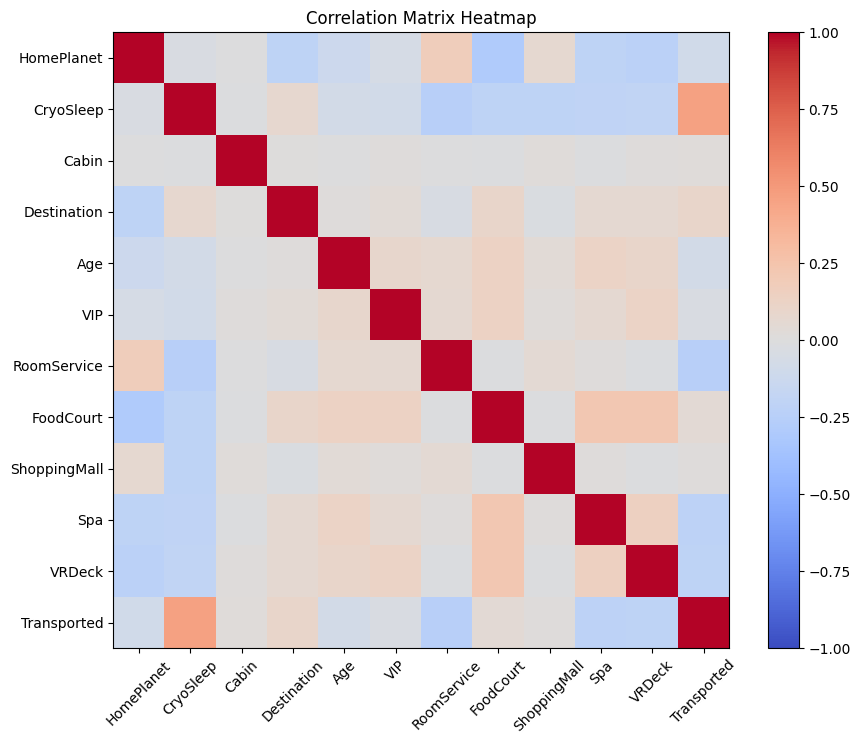

In [ ]:


fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)
ax.set_title('Correlation Matrix Heatmap')
plt.colorbar(heatmap)
plt.show()
    

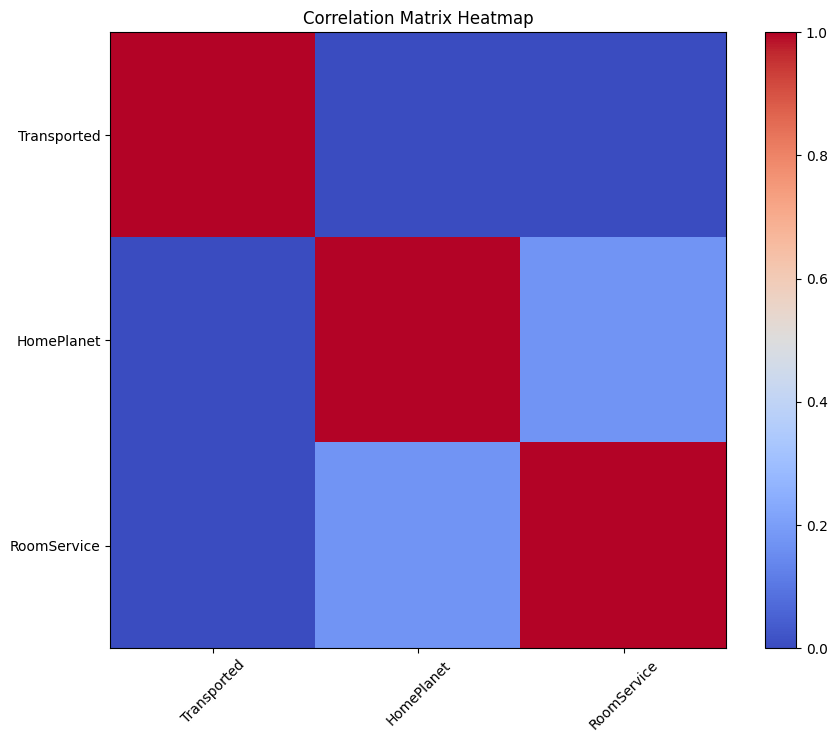

In [ ]:
# Extract the index labels of the highly correlated features
highly_correlated_cols = [pair[0] for pair in highly_correlated.index.tolist()]

# Create a correlation matrix of the highly correlated features
corr_matrix = df[highly_correlated_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.imshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=45)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)
ax.set_title('Correlation Matrix Heatmap')
plt.colorbar(heatmap)
plt.show()